# GAN実装

### import

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

モデルの次元入力

In [9]:
img_rows = 28
img_cols = 28
channel = 1

#入力画像の次元
img_shape = (img_rows, img_cols, channel)

#生成機の入力として使われるノイズベクトルの次元
z_dim = 100


### 生成器の実装

In [10]:
def build_gengerator(img_shape, z_dim):
    
    model = Sequential()
    
    #DENSE：全結合層、隠れそうの数：128、入力次元：100（ノイズベクトル）
    model.add(Dense(128, input_dim = z_dim))
    
    #活性化関数（Leaky_ReLU）
    model.add(LeakyReLU(alpha = 0.01))
    
    #tanhを使った出力層
    model.add(Dense(28*28*1, activation = 'tanh'))
    
    #生成機の形が画像サイズになるようにreshape
    model.add(Reshape(img_shape))
    
    return model

生成器で行っていることは全部で３つ
1. 隠れ層が128層のNNを構築（入力層は100次元のノイズベクトル）
2. 活性化関数はLeakyReLU
3. 出力層は28 × 28 × 1（MNISTの層に合わせている）、活性化関数はtanh([0, 1]区間の中に入れたいため。)


### 識別器

In [11]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    #入力画像を1列に（28*28）, 入力データは28*28*1
    model.add(Flatten(input_shape = img_shape))
    
    #全結合層, 層の数は生成器と同じく128
    model.add(Dense(128))
    
    #Leaky_ReLUによる活性化
    model.add(LeakyReLU(alpha = 0.01))
    
    #sigmoid関数を通して出力（[0, 1]の範囲に収めたい）
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

識別器で行っていること

1. 入力データが28 × 28 × 1なので1次元に直すためのFlatten
2. NNの層は全結合層（Dense）, 層の数は128
3. 活性化関数はReakyReLU
4. 出力層は1次元,(0, 1)の範囲に収めるため（本物か偽物か判断したいから）sigmoid関数を用いる。


### モデルの作成

In [12]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    #生成器と識別器の結合　
    model.add(generator)
    model.add(discriminator)
    
    return model

#識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy'
                    , optimizer = Adam()
                    , metrics = ['accuracy'])

#生成器の構築
generator = build_gengerator(img_shape, z_dim)

#生成器の構築中は識別器のパラメータを固定
discriminator.trainable = False

#生成器の訓練中のため識別器は固定しGANモデルの構築とコンパイルを行う
gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

先に実装した識別器と生成器を用いてコンパイル。<br>

生成器を訓練させる ⇨ discriminator.trainable = Falseとして識別器のパラメータを固定。<br>
これにより、生成器のみを訓練させることが可能。<br>
識別器は別にコンパイルされたモデルで訓練させる。<br>

訓練中に再消化する損失関数としては「二値交差エントロピー(Binary Cross Entropy)」を用いる 。<br>
- 二値交差エントロピー
    可能な分類クラスが2つだけの場合に計算された確率分布と実際の確率分布の差を測る。<br>
    交差エントロピ損失がおきくなるほど推定結果が正解のラベルから遠のいてしまう。

各ネットワークの最適化の手法にはAdamを用いている。<br>
Adam：優れた勾配降下法ベースの最適化の手段。ほとんどのGANで推奨されている最適化手法。<br>

generatorをコンパイルしていない理由：generatorは単体では学習しないため（discriminatorを騙すように学習する。）

### 訓練

In [13]:
losses = []
accuracies = []
iterati0n_checkpoint = []

def train(iterations, batch_size, sample_interval):
    
    #MNISTのデータセットのロード
    (X_train, _), (_, _) = mnist.load_data()
    
    #[0, 255]の範囲のグレースケール画素値を[-1, 1]にスケーリング
    X_train = X_train/127.5 - 1.0
    X_train = np.expand_dims(X_train, axis = 3)
    
    #本物の画像ラベルは全て1とする
    real = np.ones((batch_size, 1))
    
    #偽物のラベルは0とする
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        #--------------
        #識別器の訓練
        #--------------
        
        #本物の画像をランダムに取り出したバッチを作る
        idx = np.random.randint(0, X_train.shape[0], batch_size) #0~X_train.shapeの間で128この乱数を生成（ランダムに取り出すため）
        imgs = X_train[idx]
        
        #偽の画像バッチを作成する
        z = np.random.randint(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        #識別器の訓練
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(imgs, fake)
        d_loss, accuracy = 0.5*np.add(d_loss_real, d_loss_fake)
        
        #--------------
        #生成期の訓練
        #--------------
        
        #偽の画像のバッチを作成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        #生成器の訓練
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration+1)%sample_interval == 0:
            
            #訓練終了後に図示するために、損失と精度をセーブしておく
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iterati0n_checkpoint.append(iteration+1)
            
            #訓練の進捗を出力
            print('%d [D loss: %f, acc.: %.2f%%] [G loss: $%f]'% (iteration+1, d_loss, 100.0*accuracy, g_loss))
            
            #生成されたサンプルを出力する
            sample_images(generator)

### 生成された画像の表示

In [14]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    
    #ランダムノイズのサンプリング
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    #ランダムノイズを使って画像を生成する
    gen_imgs = generator.predict(z)
    
    #画像の画素を[0, 1]の範囲に
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    #画像をグリッドに並べる
    fix, axs = plt.subplots(image_grid_rows
                         , image_grid_columns
                         , figsize = (4, 4)
                         , sharey = True
                         , sharex = True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            #並べた画像を出力する
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].axis('off')
            cnt += 1

### モデルの実行

1000 [D loss: 0.693309, acc.: 41.80%] [G loss: $0.000876]
2000 [D loss: 0.693267, acc.: 37.89%] [G loss: $0.003435]
3000 [D loss: 0.693240, acc.: 37.50%] [G loss: $0.011601]
4000 [D loss: 0.693213, acc.: 42.58%] [G loss: $0.038096]
5000 [D loss: 0.693194, acc.: 38.28%] [G loss: $0.110016]
6000 [D loss: 0.693183, acc.: 40.23%] [G loss: $0.266271]
7000 [D loss: 0.693175, acc.: 50.00%] [G loss: $0.533426]
8000 [D loss: 0.693175, acc.: 50.00%] [G loss: $0.690708]
9000 [D loss: 0.693171, acc.: 2.34%] [G loss: $0.694430]
10000 [D loss: 0.693170, acc.: 43.75%] [G loss: $0.694359]
11000 [D loss: 0.693168, acc.: 50.00%] [G loss: $0.694324]
12000 [D loss: 0.693172, acc.: 50.00%] [G loss: $0.642838]
13000 [D loss: 0.693179, acc.: 38.28%] [G loss: $0.686543]
14000 [D loss: 0.693172, acc.: 30.86%] [G loss: $0.642281]
15000 [D loss: 0.693174, acc.: 41.80%] [G loss: $0.681785]
16000 [D loss: 0.693170, acc.: 47.27%] [G loss: $0.693064]
17000 [D loss: 0.693171, acc.: 50.00%] [G loss: $0.692996]
18000 [

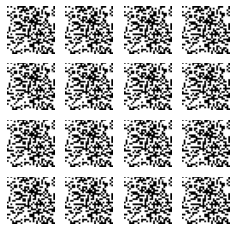

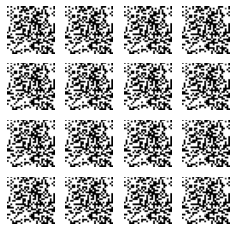

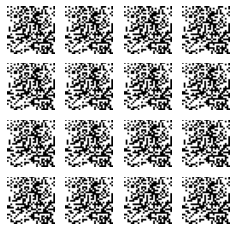

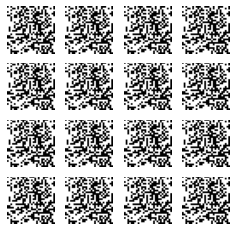

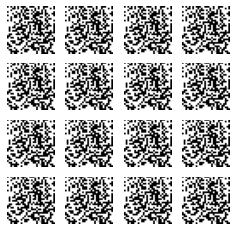

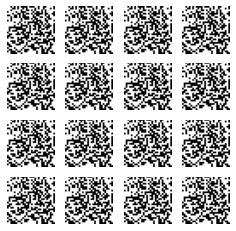

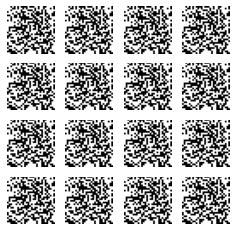

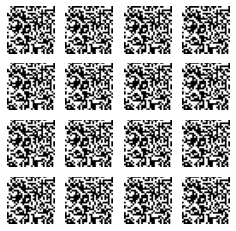

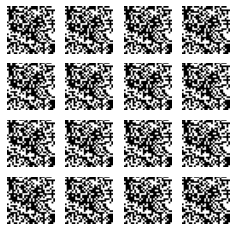

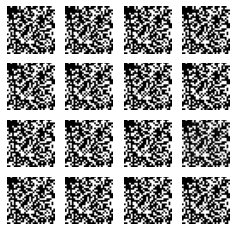

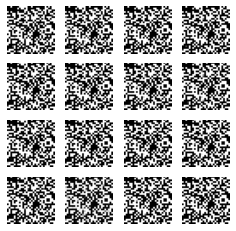

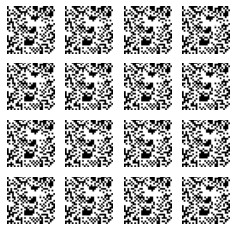

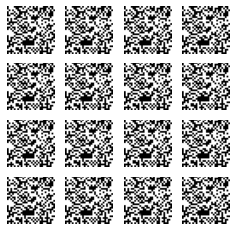

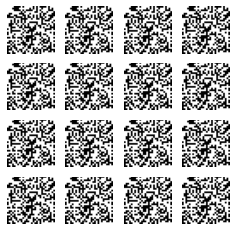

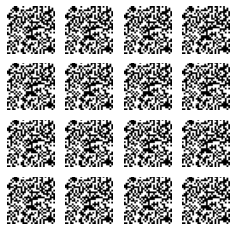

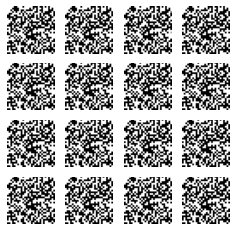

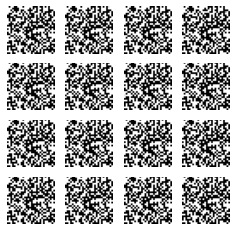

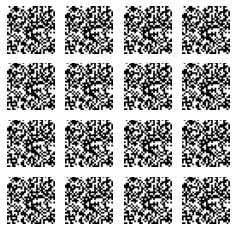

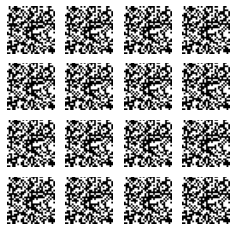

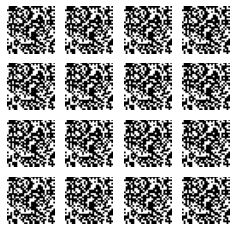

In [35]:
#ハイパーパラメータの設定
iterations = 20000
batch_size = 128
sample_interval = 1000

#設定した反復回数だけGANの訓練を行う。}
train(iterations, batch_size, sample_interval)

- Versionが古いからなんとかする。

WARNING:tensorflow:From /Users/yusuke/opt/anaconda3/envs/signate/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.